In [1]:
from treecalculator import TreeCalculator
from treemodel import TreeModel
import pickle
import cv2
import numpy as np
from skimage.filters.rank import entropy, mean
from skimage.morphology import square
import math
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [46]:
ada_model = pickle.load(open('TrainedModelManualZoom16.p', 'rb'))
images = pickle.load(open('images-lausanne-zoom-16.p', 'rb'))['sat']

tree_model = TreeModel(ada_model)


tree_calculator = TreeCalculator(tree_model)

In [51]:
results = {
    'sat': [],
    'pred': []
}

for i, img in enumerate(images):
    pred = tree_model.predict_proba(images[i])
    results['sat'].append(img)
    results['pred'].append(pred)
    print('Processed image {}/{}'.format(i+1, len(images)))

C:\Users\serge\Documents\EPFL\Personal Interaction Studio\Code\satfunctions.py:16: RuntimeWarning: divide by zero encountered in log
  alpha * np.log(img[:, :, 2] / float(255)) -
C:\Users\serge\Documents\EPFL\Personal Interaction Studio\Code\satfunctions.py:16: RuntimeWarning: invalid value encountered in subtract
  alpha * np.log(img[:, :, 2] / float(255)) -
C:\Users\serge\Documents\EPFL\Personal Interaction Studio\Code\satfunctions.py:17: RuntimeWarning: divide by zero encountered in log
  (1 - alpha) * np.log(img[:, :, 0] / float(255)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Processed image 1/702


C:\Users\serge\Documents\EPFL\Personal Interaction Studio\Code\satfunctions.py:17: RuntimeWarning: invalid value encountered in subtract
  (1 - alpha) * np.log(img[:, :, 0] / float(255)))


Processed image 2/702
Processed image 3/702
Processed image 4/702
Processed image 5/702
Processed image 6/702
Processed image 7/702
Processed image 8/702
Processed image 9/702
Processed image 10/702
Processed image 11/702
Processed image 12/702
Processed image 13/702
Processed image 14/702
Processed image 15/702
Processed image 16/702
Processed image 17/702
Processed image 18/702
Processed image 19/702
Processed image 20/702
Processed image 21/702
Processed image 22/702
Processed image 23/702
Processed image 24/702
Processed image 25/702
Processed image 26/702
Processed image 27/702
Processed image 28/702
Processed image 29/702
Processed image 30/702
Processed image 31/702
Processed image 32/702
Processed image 33/702
Processed image 34/702
Processed image 35/702
Processed image 36/702
Processed image 37/702
Processed image 38/702
Processed image 39/702
Processed image 40/702
Processed image 41/702
Processed image 42/702
Processed image 43/702
Processed image 44/702
Processed image 45/

Processed image 348/702
Processed image 349/702
Processed image 350/702
Processed image 351/702
Processed image 352/702
Processed image 353/702
Processed image 354/702
Processed image 355/702
Processed image 356/702
Processed image 357/702
Processed image 358/702
Processed image 359/702
Processed image 360/702
Processed image 361/702
Processed image 362/702
Processed image 363/702
Processed image 364/702
Processed image 365/702
Processed image 366/702
Processed image 367/702
Processed image 368/702
Processed image 369/702
Processed image 370/702
Processed image 371/702
Processed image 372/702
Processed image 373/702
Processed image 374/702
Processed image 375/702
Processed image 376/702
Processed image 377/702
Processed image 378/702
Processed image 379/702
Processed image 380/702
Processed image 381/702
Processed image 382/702
Processed image 383/702
Processed image 384/702
Processed image 385/702
Processed image 386/702
Processed image 387/702
Processed image 388/702
Processed image 

Processed image 690/702
Processed image 691/702
Processed image 692/702
Processed image 693/702
Processed image 694/702
Processed image 695/702
Processed image 696/702
Processed image 697/702
Processed image 698/702
Processed image 699/702
Processed image 700/702
Processed image 701/702
Processed image 702/702


In [52]:
pickle.dump(results, open('NonThresholdedPredictedDataLausanne16.p', 'wb'))

In [3]:
results = pickle.load(open('NonThresholdedPredictedDataLausanne16.p', 'rb'))

In [67]:
sparsities = []
coverages = []
for pred in results['pred']:
    binary_pred = tree_calculator.threshold_image(tree_calculator.filter_image(pred))
    coverages.append(np.count_nonzero(binary_pred) / binary_pred.size)
    ret, thresh_entropy = cv2.threshold(entropy(binary_pred, square(10)), 0.5, 1, cv2.THRESH_BINARY)
    entropy_zero_count = np.count_nonzero(thresh_entropy)
    normal_zero_count = np.count_nonzero(binary_pred)
    if normal_zero_count == 0:
        sparsity = 0
    elif entropy_zero_count == 0:
        sparsity = pred.size
    else:
        sparsity = np.count_nonzero(binary_pred) / entropy_zero_count if entropy_zero_count > 0 else pred.size
#     sparsity /= pred.size
    sparsities.append(sparsity)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [68]:
pickle.dump({'spars': sparsities, 'cov': coverages}, open('CoveragesAndSparsitiesDataLausanne16.p', 'wb'))

In [4]:
data = pickle.load(open('CoveragesAndSparsitiesDataLausanne16.p', 'rb'))
sparsities = data['spars']
coverages = data['cov']

In [69]:
sparsities = np.array(sparsities)
coverages = np.array(coverages)

arg_sorted_sparsities = np.argsort(sparsities)
arg_sorted_coverages = np.argsort(coverages)
    
reordered_sparsities = sparsities[arg_sorted_sparsities]
reordered_coverages = coverages[arg_sorted_sparsities]

In [70]:
dim = 10
block_size = int(len(sparsities) / dim)
sub_block_size = int(block_size / dim)
idx_matrix = np.empty((dim, dim), dtype=np.int32)
for i in range(dim):
    c_arg_sparsities = arg_sorted_sparsities[i*block_size:(i+1)*block_size]
    c_arg_coverages = []
    for arg_spars in c_arg_sparsities:
        c_arg_coverages.append(np.where(arg_sorted_coverages == arg_spars)[0][0])
    c_sorted_arg_coverages = np.argsort(c_arg_coverages)
    c_shrinked_sorted_arg_coverages = c_sorted_arg_coverages[::sub_block_size]
    for j in range(dim):
        idx = c_arg_sparsities[c_shrinked_sorted_arg_coverages[j]]
        idx_matrix[i,j] = idx

In [117]:
fig_size_a2 = (16.54, 23.39)

f, axarr = plt.subplots(dim, dim,
                        sharex='all',
                        sharey='all',
                        figsize=fig_size_a2,
                        tight_layout = {'pad': 0})
f.text(0.01, 0.01, 'Increasing Density →', ha='left')
f.text(0.01, 0.99, '← Decreasing Sparsity', va='top', rotation='vertical')
for y in range(dim):
    for x in range(dim):
        axarr[y,x].axis('off')
        axarr[y,x].imshow(results['sat'][idx_matrix[y,x]], cmap=plt.cm.Greens)
f.savefig('MidTerm/Poster/output1.pdf', dpi=300)
plt.close(f)

f, axarr = plt.subplots(dim, dim,
                        sharex='all',
                        sharey='all',
                        figsize=fig_size_a2,
                        tight_layout = {'pad': 0})
f.text(0.01, 0.01, 'Increasing Density →', ha='left')
f.text(0.01, 0.99, '← Decreasing Sparsity', va='top', rotation='vertical')
for y in range(dim):
    for x in range(dim):
        axarr[y,x].axis('off')
        axarr[y,x].imshow(results['pred'][idx_matrix[y,x]], cmap=plt.cm.Greens)
f.savefig('MidTerm/Poster/output2.pdf', dpi=300)
plt.close(f)

f, axarr = plt.subplots(dim, dim,
                        sharex='all',
                        sharey='all',
                        figsize=fig_size_a2,
                        tight_layout = {'pad': 0})
f.text(0.01, 0.01, 'Increasing Density →', ha='left')
f.text(0.01, 0.99, '← Decreasing Sparsity', va='top', rotation='vertical')
for y in range(dim):
    for x in range(dim):
        axarr[y,x].axis('off')
        binary_pred = tree_calculator.threshold_image(tree_calculator.filter_image(results['pred'][idx_matrix[y,x]]))
        axarr[y,x].imshow(binary_pred, cmap=plt.cm.Greens)
f.savefig('MidTerm/Poster/output3.pdf', dpi=300)
plt.close(f)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  if __name__ == '__main__':
C:\Users\serge\Documents\EPFL\Personal Interaction Studio\Code\satfunctions.py:16: RuntimeWarning: divide by zero encountered in log
  alpha * np.log(img[:, :, 2] / float(255)) -
C:\Users\serge\Documents\EPFL\Personal Interaction Studio\Code\satfunctions.py:16: RuntimeWarning: invalid value encountered in subtract
  alpha * np.log(img[:, :, 2] / float(255)) -
C:\Users\serge\Documents\EPFL\Personal Interaction Studio\Code\satfunctions.py:17: RuntimeWarning: divide by zero encountered in log
  (1 - alpha) * np.log(img[:, :, 0] / float(255)))
C:\Users\serge\Documents\EPFL\Personal Interaction Studio\Code\satfunctions.py:17: RuntimeWarning: invalid value encountered in subtract
  (1 - alpha) * np.log(img[:, :, 0] / float(255)))
C:\ProgramData\Anaconda

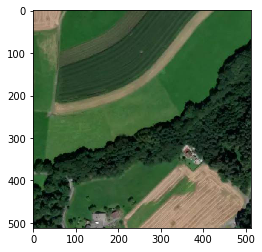

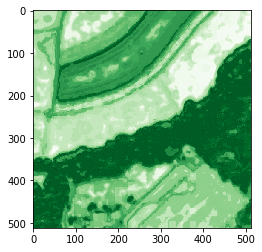

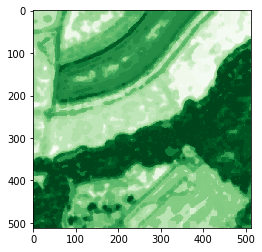

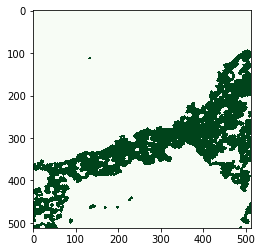

In [119]:
import matplotlib as mpl
import matplotlib.cm as cm

scal_map = cm.ScalarMappable(cmap=plt.cm.Greens)

img = results['sat'][idx_matrix[9,1]]
plt.figure()
plt.imshow(img)
scipy.misc.imsave('MidTerm/Examples/sat.png', img)
predict = tree_model.predict_proba(img)
plt.figure()
plt.imshow(predict, cmap=plt.cm.Greens)
scipy.misc.imsave('MidTerm/Examples/sat_predicted.png', scal_map.to_rgba(predict))
filtered = tree_calculator.filter_image(predict)
plt.figure()
plt.imshow(filtered, cmap=plt.cm.Greens)
scipy.misc.imsave('MidTerm/Examples/sat_predicted_filtered.png', scal_map.to_rgba(filtered))
# thresholded = tree_calculator.threshold_image(predict)
# plt.figure()
# plt.imshow(thresholded)
first_filter_then_threshold = tree_calculator.threshold_image(filtered)
plt.figure()
plt.imshow(first_filter_then_threshold, cmap=plt.cm.Greens)
scipy.misc.imsave('MidTerm/Examples/sat_predicted_filtered_thresholded.png', scal_map.to_rgba(first_filter_then_threshold))
# first_threshold_then_filter = tree_calculator.filter_image(thresholded)
# plt.figure()
# plt.imshow(first_threshold_then_filter)

# print(idx_matrix[2,7])
# print(idx_matrix[0,7])
# idx = idx_matrix[2,7]
# print(idx)
# print(sparsities[idx])
# print(coverages[idx])
# plt.imshow(results['sat'][idx])
# plt.figure()
# plt.imshow(results['pred'][idx])
# plt.figure()
# plt.imshow(tree_calculator.threshold_image(tree_calculator.filter_image(results['pred'][idx]), threshold=0.48))
# plt.figure()
# plt.imshow(tree_calculator.threshold_image(tree_calculator.filter_image(results['pred'][idx])))

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


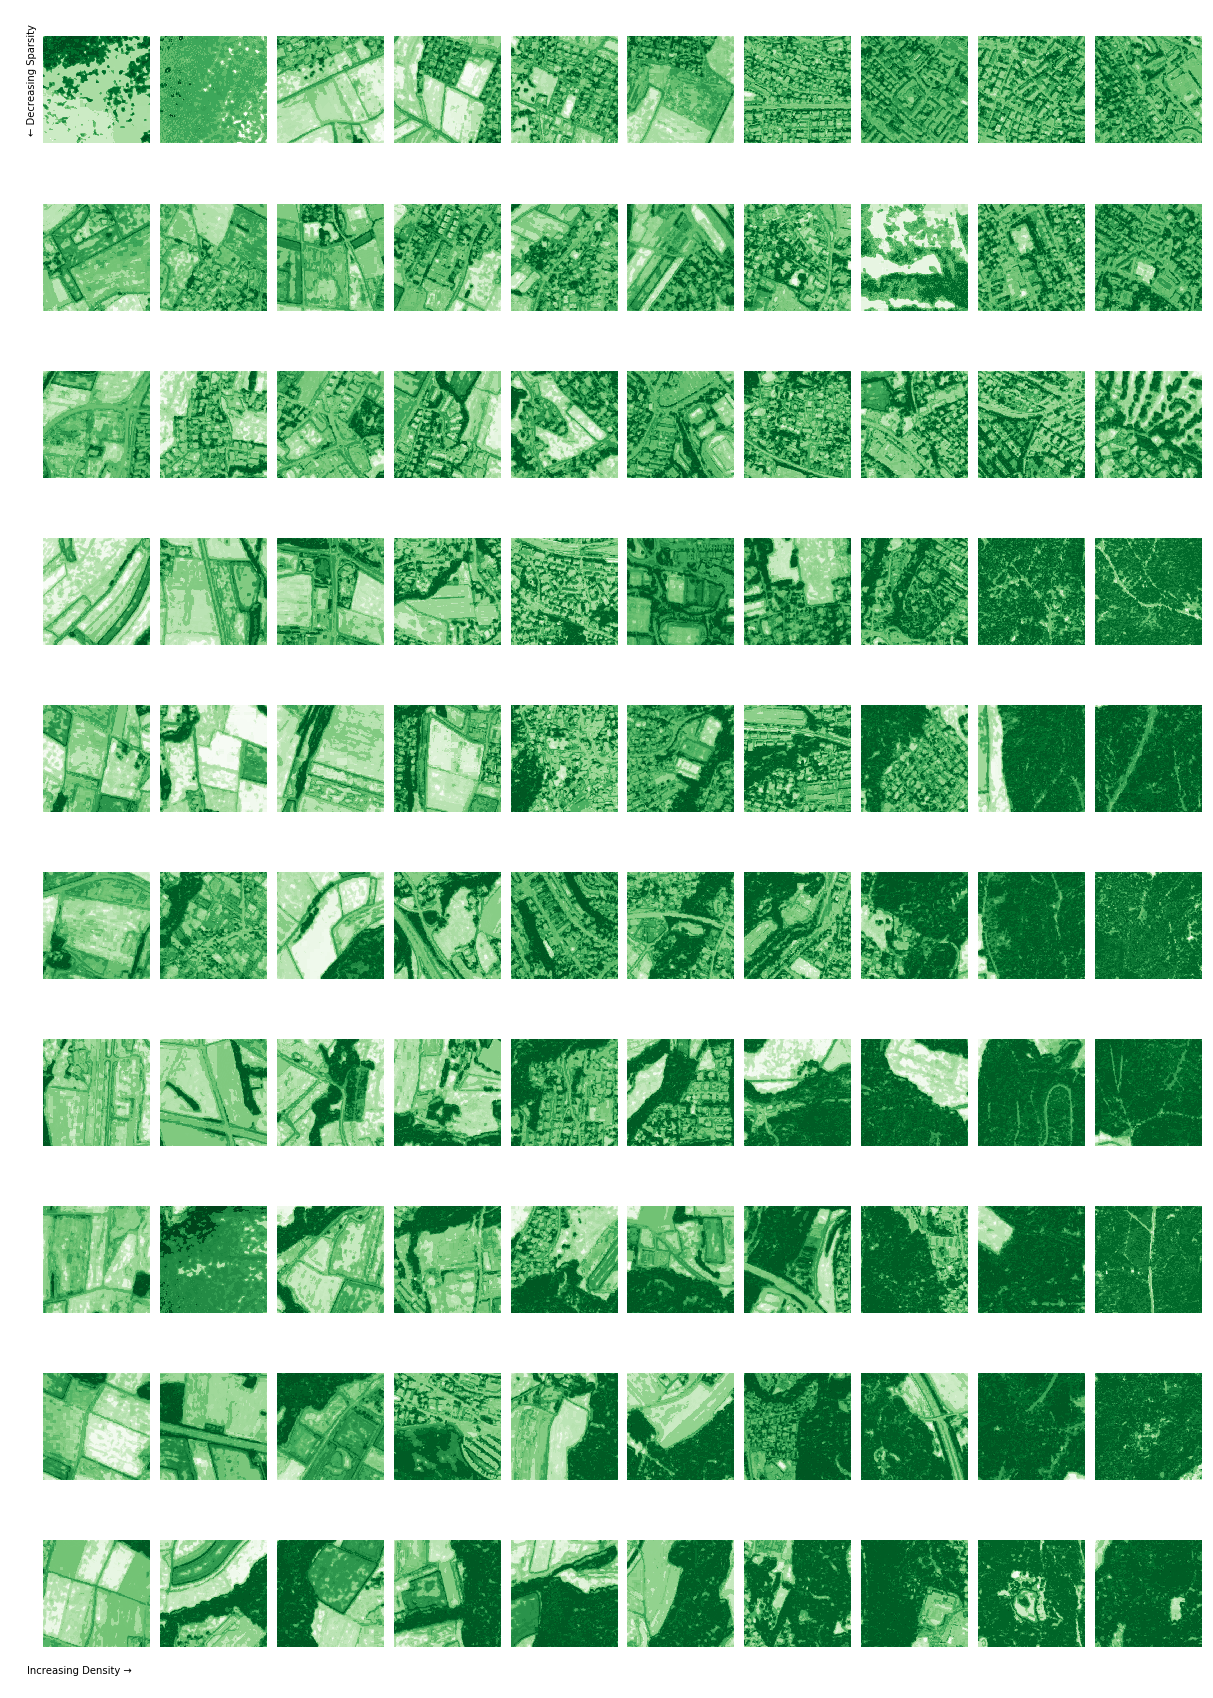

In [116]:
fig_size_a2 = (16.54, 23.39)

f, axarr = plt.subplots(dim, dim,
                        sharex='all',
                        sharey='all',
                        figsize=fig_size_a2,
                        tight_layout = {'pad': 0})

f.text(0.01, 0.01, 'Increasing Density →', ha='left')
f.text(0.01, 0.99, '← Decreasing Sparsity', va='top', rotation='vertical')
for y in range(dim):
    for x in range(dim):
        axarr[y,x].axis('off')
        axarr[y,x].imshow(results['pred'][idx_matrix[y,x]], cmap=plt.cm.Greens)